


# XGBoost Algorithm



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import set_printoptions

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from imblearn.combine import SMOTEENN

from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

In [2]:
df_ppi_1 = pd.read_csv('data/base_cerevisiae.csv')
df_ppi_2 = pd.read_csv('data/base_elegans.csv')
df_ppi_3 = pd.read_csv('data/base_drosophila.csv')

In [3]:
df = pd.concat([df_ppi_1, df_ppi_2, df_ppi_3], ignore_index=True)
df

,Locus,Sequence,Sequence_Length,Aromaticity,Sec_Struct_Helix,Sec_Struct_Turn,Sec_Struct_Sheet,Percent_A,Percent_C,Percent_D,...,Percent_V,Percent_W,Percent_Y,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,YPL071C,MSSRFARSNGNPNHIRKRNHSPDPIGIDNYKRKRLIIDLENLSLND...,156,0.096154,0.262821,0.435897,0.301282,0.044872,0.006410,0.128205,...,0.038462,0.032051,0.038462,4932.YPL071C,0.000986,0.000512,3.315435e-06,0.426787,0.266667,0
1,YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...,143,0.111888,0.293706,0.405594,0.300699,0.076923,0.006993,0.083916,...,0.083916,0.006993,0.048951,4932.YLL050C,0.053392,0.017135,2.003725e-04,0.497262,0.302355,1
2,YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,719,0.043115,0.314325,0.442281,0.243394,0.055633,0.002782,0.058414,...,0.030598,0.004172,0.018081,4932.YMR172W,0.007557,0.002314,3.144740e-06,0.438952,0.289855,0
3,YOR185C,MSAPAQNNAEVPTFKLVLVGDGGTGKTTFVKRHLTGEFEKKYIATI...,220,0.109091,0.322727,0.340909,0.336364,0.077273,0.013636,0.063636,...,0.081818,0.013636,0.040909,4932.YOR185C,0.046164,0.017683,1.040158e-04,0.491754,0.307905,0
4,YLL032C,MDNFKIYSTVITTAFLQVPHLYTTNRLWKPIEAPFLVEFLQKRISS...,825,0.100606,0.306667,0.358788,0.334545,0.042424,0.010909,0.042424,...,0.043636,0.002424,0.043636,4932.YLL032C,0.021028,0.006141,1.265410e-04,0.473128,0.236713,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30506,7227.FBpp0306211,MARLISGVRNLFHRYPFVTNSAIYGSLYVGAEYSQQFASKRWLATA...,204,0.147059,0.348039,0.269608,0.382353,0.102941,0.014706,0.029412,...,0.073529,0.029412,0.058824,7227.FBpp0306211,0.000177,0.000006,1.872049e-08,0.290879,0.000000,0
30507,7227.FBpp0306213,MVKILQAYNFARQQTYALNGDILAASLIGNNRIAISSAEQFIEIYD...,1536,0.083984,0.372396,0.333333,0.294271,0.074870,0.019531,0.052734,...,0.065104,0.005208,0.035807,7227.FBpp0306213,0.001237,0.000074,6.935191e-06,0.324301,0.648352,0
30508,7227.FBpp0306214,MSGGDYDSGDYFMRSRKQRDKPSLWDSFQDPPSKKTSGSDADWKKL...,1393,0.117014,0.384063,0.284996,0.330940,0.083274,0.022254,0.055994,...,0.071070,0.023690,0.035176,7227.FBpp0306214,0.014759,0.005067,1.719578e-04,0.421110,0.268595,0
30509,7227.FBpp0306223,MEREIAHSLAGGEERSSDVAPGQVKTFEELRLYRNLLNGLKRNNFV...,1028,0.071012,0.351167,0.381323,0.267510,0.057393,0.007782,0.052529,...,0.057393,0.003891,0.034047,7227.FBpp0306223,0.055590,0.016066,4.047679e-04,0.451477,0.227401,1


### Análise Exploratória

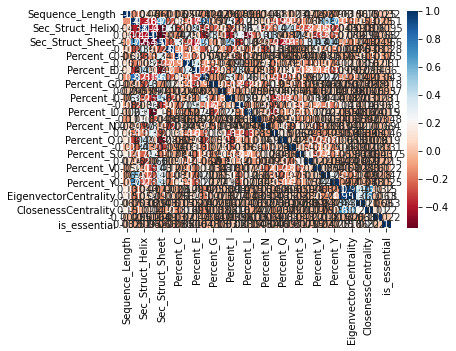

In [4]:
plt.rcParams["figure.figsize"] = (20,20)

# Matriz de Correlação com Matplotlib Seaborn incluindo a classe de predição
sns.heatmap(df.corr(), annot=True, cmap='RdBu');

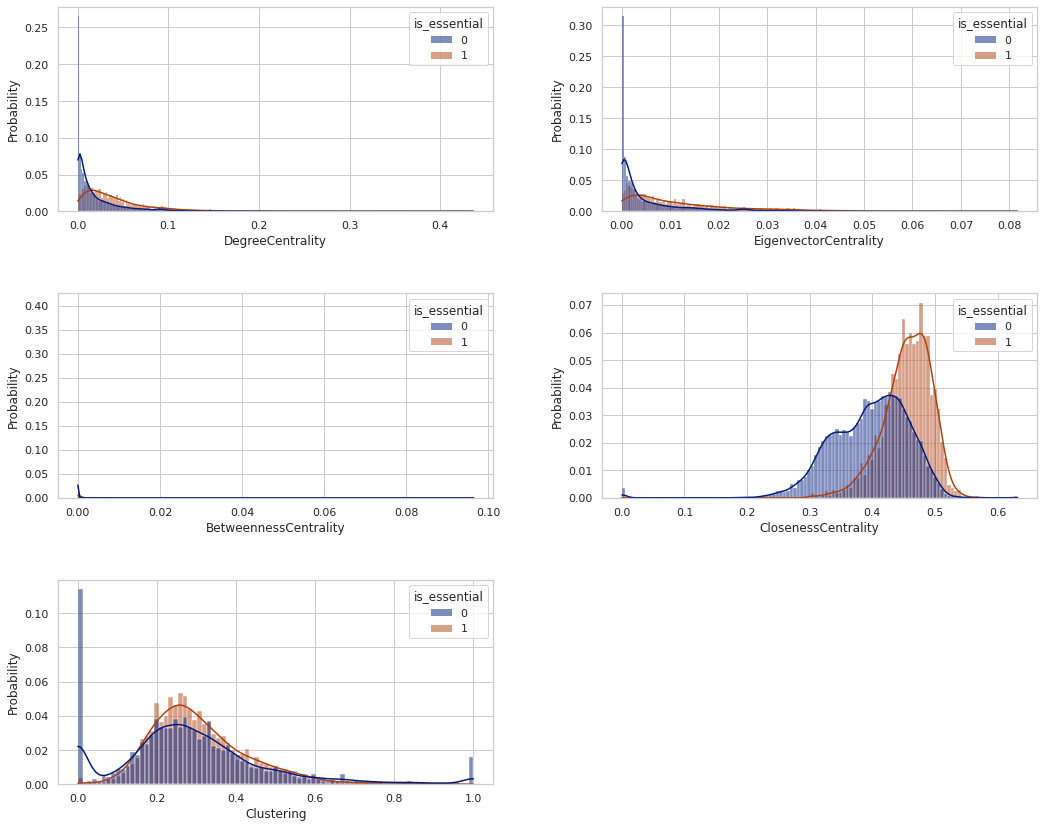

In [5]:
features = ['DegreeCentrality', 'EigenvectorCentrality', 'BetweennessCentrality',
       'ClosenessCentrality', 'Clustering']

plt.rcParams['figure.figsize'] = (16,12)

# Define as configurações dos plots
# Cada plot terá o mesmo tamanho de figuras (8,10)
#plt.style.use("ggplot")

plt.figure(1)

sns.set_theme(style="whitegrid", palette="dark")

plt.title('Distribuição dos dados - Baseadas em Sequência')

# Dados para cada subplot

for index, value in zip(range(1,6), features):
    plt.subplot(3, 2, index)
    sns.histplot(data=df, x=value, hue="is_essential", 
             stat="probability", common_norm=False, kde=True)

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)

plt.savefig("results_centrality.jpg")
plt.show()


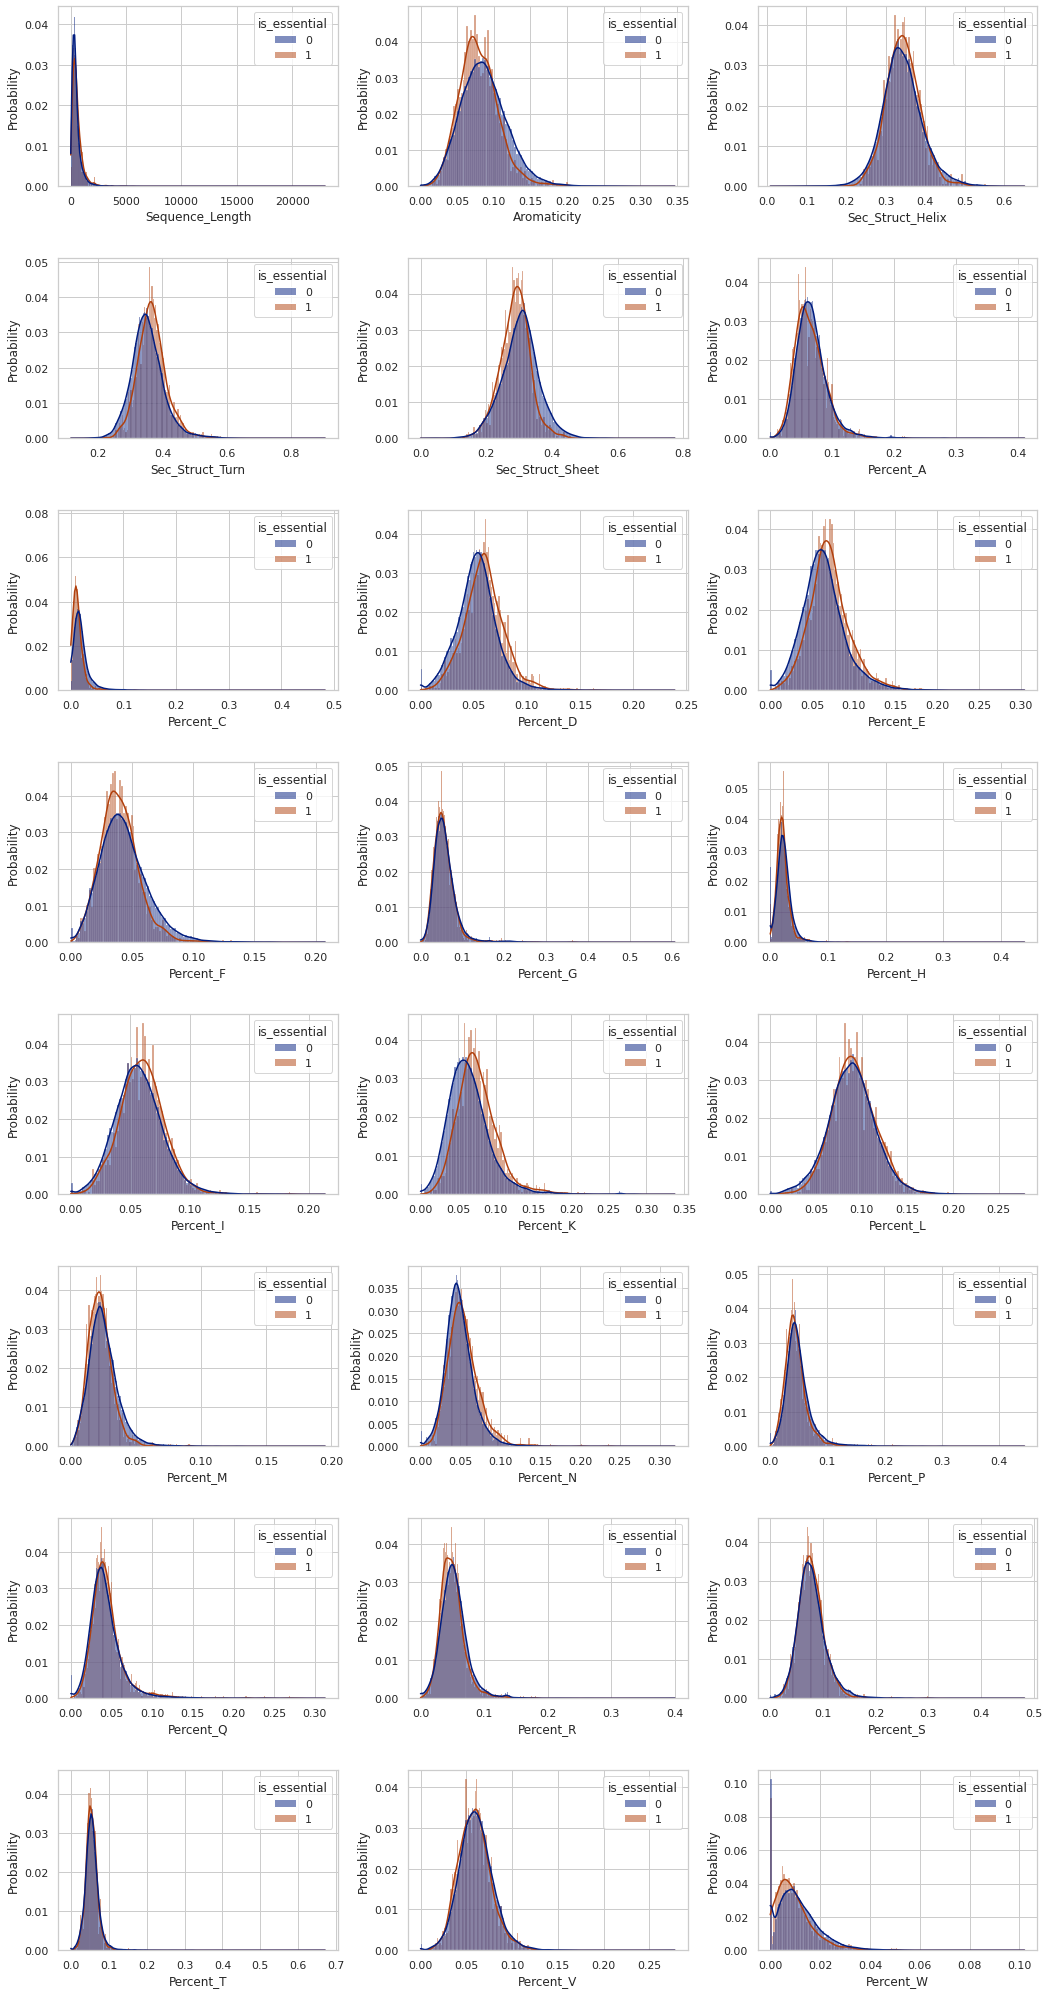

In [6]:
features_seq = ['Sequence_Length', 'Aromaticity', 'Sec_Struct_Helix',
       'Sec_Struct_Turn', 'Sec_Struct_Sheet', 'Percent_A', 'Percent_C',
       'Percent_D', 'Percent_E', 'Percent_F', 'Percent_G', 'Percent_H',
       'Percent_I', 'Percent_K', 'Percent_L', 'Percent_M', 'Percent_N',
       'Percent_P', 'Percent_Q', 'Percent_R', 'Percent_S', 'Percent_T',
       'Percent_V', 'Percent_W', 'Percent_Y']


plt.rcParams['figure.figsize'] = (16,30)

plt.figure(1)

sns.set_theme(style="whitegrid", palette="dark")

plt.title('Distribuição dos dados - Medidas de Centralidade e Clustering')

# Dados para cada subplot

for index, value in zip(range(1,25), features_seq):
    plt.subplot(8, 3, index)
    sns.histplot(data=df, x=value, hue="is_essential", 
             stat="probability", common_norm=False, kde=True)
    

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)

plt.savefig("results_sequence.jpg")
plt.show()

### Funções

In [7]:
# Função para validação cruzada sem o uso de balanceamento na amostra de validação

def validacao_cruzada(model, X, y, sampling = False, method_sampling = None):
    kfold = KFold(n_splits = 5, shuffle=True)
    
    acuracias_split = []
    
    for idx, (idx_treino, idx_validacao) in enumerate(kfold.split(X)):
        X_split_treino = X.iloc[idx_treino, :]
        y_split_treino = y.iloc[idx_treino, :]
        
        
        if sampling: 
            # Método de Sampling
            sm = method_sampling
            X_split_treino, y_split_treino = sm.fit_resample(X_split_treino, y_split_treino)
            
        model.fit(X_split_treino, y_split_treino.values.ravel())  
        
        X_split_validacao = X.iloc[idx_validacao, :]
        y_split_validacao = y.iloc[idx_validacao, :]
        
        
        pred_validacoes = model.predict(X_split_validacao)
        
        acuracia_split = accuracy_score(y_split_validacao, pred_validacoes)
        
        acuracias_split.append(acuracia_split)
        
        print(f'Acurácia do split {idx}: {acuracia_split}')
        
        mean = np.mean(acuracias_split)
        
    return print(f'Média de Acurácia na validação cruzada: {mean}')

## Pré-processamento de Dados

In [8]:
# Separação em conjuntos de treino e teste
X = df.drop(['Protein_key','is_essential', 'Locus', 'Sequence'], axis=1)
#X = df_select
y = df[['is_essential']]
test_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=seed, 
                                                    stratify=y)

### PCA

https://jmausolf.github.io/code/pca_in_python/

In [83]:
## Padronizando os dados com StandardScaler
scaler = StandardScaler()

# Paronizando com PCA dados de treino e teste
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)

scaled_test = scaler.transform(X_test)

In [86]:
# Define PCA model
pca = PCA(n_components=15).fit(scaled_train)

# Transformando com PCA dados de treino e teste
X_train_pca = pca.transform(scaled_train)
X_test_pca = pca.transform(scaled_test)


total_var = pca.explained_variance_ratio_.sum() * 100

print(f'Total Explained Variance: {total_var:.2f}%')

Total Explained Variance: 81.96%


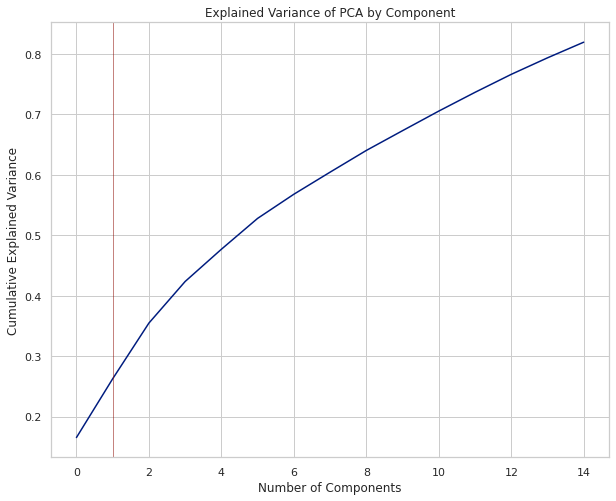

In [87]:
import numpy as np
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator

def var_explained():
    ax = figure().gca()
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axvline(x=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Explained Variance of PCA by Component')
    show()

var_explained()

### Sampling

In [10]:
## Undersampling

undersample = RandomUnderSampler(random_state=seed)

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

y_train_under.value_counts()

is_essential
0               1334
1               1334
dtype: int64

In [11]:
## Oversampling

oversample = SMOTE(random_state=seed)

X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

y_train_over.value_counts()

is_essential
0               23074
1               23074
dtype: int64

In [12]:
## Combine

sample = SMOTEENN(random_state=seed)
#sample = SMOTETomek(random_state=seed)

X_train_sample, y_train_sample = sample.fit_resample(X_train, y_train)

y_train_sample.value_counts()

is_essential
1               20159
0               16386
dtype: int64

## Algoritmo XGBoost

In [32]:
xgbc = XGBClassifier(n_estimators=300, max_depth=8, booster= 'gbtree', 
                     verbosity=2, random_state = seed)

# Training the XGB classifier
xgbc.fit(X_train_sample, y_train_sample)

[22:21:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[22:21:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=8
[22:21:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=8
[22:21:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=8
[22:21:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[22:21:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[22:21:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[22:21:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[22:21:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 288 extra nodes, 0 pruned no

[22:21:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=8
[22:21:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[22:21:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=8
[22:21:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=8
[22:21:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=8
[22:21:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=8
[22:21:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=8
[22:21:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=8
[22:21:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned no

[22:21:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=8
[22:21:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=8
[22:21:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=8
[22:21:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=8
[22:21:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=8
[22:21:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=8
[22:21:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[22:21:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=8
[22:21:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes

[22:21:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=8
[22:21:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[22:21:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[22:21:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=8
[22:21:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[22:21:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=8
[22:21:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[22:21:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:21:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 136 extra nodes, 0 pruned nodes, m

[22:21:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

Text(0.5, 1.0, 'Importância de cada feature')

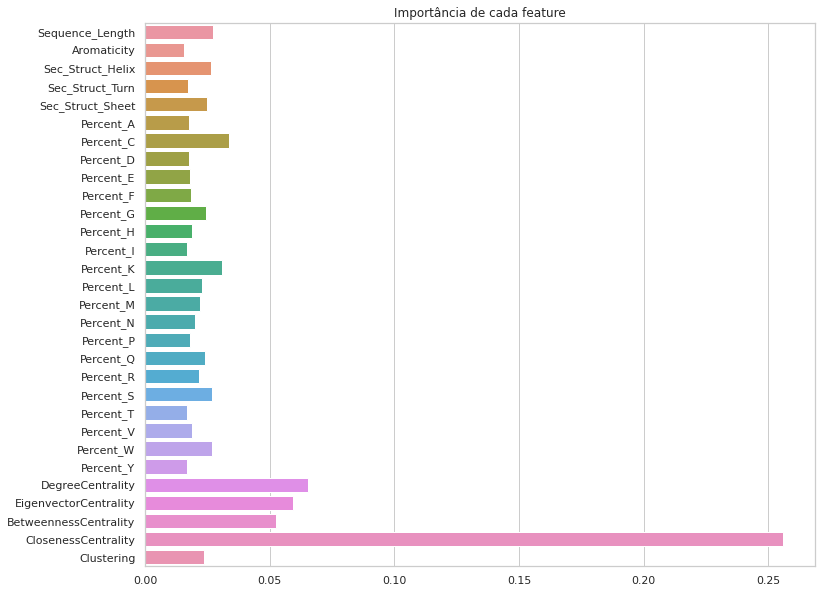

In [33]:
# Verificando a importância das features

plt.rcParams['figure.figsize'] = (12,10)

importances = pd.Series(data=xgbc.feature_importances_, index=X_train.columns.values)

sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [34]:
# Validação cruzada 
validacao_cruzada(xgbc, X_train, y_train, True, sample)

[22:21:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[22:21:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[22:21:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[22:21:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=8
[22:21:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=8
[22:21:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=8
[22:21:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=8
[22:21:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=8
[22:21:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 198 extra nodes, 0 pruned no

[22:21:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=8
[22:21:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=8
[22:21:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=8
[22:21:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=8
[22:21:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=8
[22:21:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=8
[22:21:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=8
[22:21:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=8
[22:21:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes

[22:21:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=8
[22:21:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=8
[22:21:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=8
[22:21:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[22:21:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[22:21:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[22:21:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=8
[22:21:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=8
[22:21:58] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, ma

[22:22:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[22:22:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=8
[22:22:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[22:22:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=8
[22:22:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=8
[22:22:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=8
[22:22:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[22:22:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[22:22:03] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_

[22:22:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[22:22:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[22:22:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[22:22:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[22:22:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=8
[22:22:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=8
[22:22:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[22:22:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=8
[22:22:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 182 extra nodes, 0 pruned no

[22:22:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[22:22:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[22:22:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=8
[22:22:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=8
[22:22:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=8
[22:22:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=8
[22:22:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[22:22:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=8
[22:22:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes,

[22:22:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=8
[22:22:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=8
[22:22:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[22:22:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=8
[22:22:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=8
[22:22:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=8
[22:22:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=8
[22:22:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=8
[22:22:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes,

[22:22:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=8
[22:22:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[22:22:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[22:22:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=8
[22:22:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[22:22:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=8
[22:22:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[22:22:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[22:22:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_

[22:22:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[22:22:34] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
Acurácia do split 1: 0.8795575583777141
[22:22:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=8
[22:22:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=8
[22:22:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=8
[22:22:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=8
[22:22:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[22:22:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[22:22:37] INFO: ../src/tree/updater_prune.cc:98: tree pru

[22:22:42] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=8
[22:22:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=8
[22:22:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[22:22:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=8
[22:22:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=8
[22:22:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=8
[22:22:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=8
[22:22:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=8
[22:22:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes

[22:22:48] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=8
[22:22:48] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=8
[22:22:48] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=8
[22:22:48] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=8
[22:22:48] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=8
[22:22:48] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=8
[22:22:48] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=8
[22:22:48] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=8
[22:22:48] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, ma

[22:22:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=8
[22:22:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[22:22:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[22:22:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=8
[22:22:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=8
[22:22:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[22:22:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=8
[22:22:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=8
[22:22:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_

[22:22:57] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[22:22:57] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=8
Acurácia do split 2: 0.8850880786562884
[22:22:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=8
[22:23:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=8
[22:23:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=8
[22:23:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[22:23:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[22:23:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=8
[22:23:00] INFO: ../src/tree/updater_prune.cc:98: tree pru

[22:23:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=8
[22:23:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[22:23:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=8
[22:23:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=8
[22:23:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=8
[22:23:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=8
[22:23:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=8
[22:23:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=8
[22:23:05] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 188 extra nodes, 0 pruned nod

[22:23:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[22:23:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=8
[22:23:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=8
[22:23:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=8
[22:23:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=8
[22:23:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[22:23:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=8
[22:23:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=8
[22:23:10] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes,

[22:23:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[22:23:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=8
[22:23:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=8
[22:23:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=8
[22:23:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[22:23:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=8
[22:23:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[22:23:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[22:23:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max

[22:23:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=8
[22:23:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
Acurácia do split 3: 0.8635525507068224
[22:23:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[22:23:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[22:23:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=8
[22:23:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[22:23:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=8
[22:23:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[22:23:21] INFO: ../src/tree/updater_prune.cc:98: tree pru

[22:23:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=8
[22:23:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=8
[22:23:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=8
[22:23:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=8
[22:23:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=8
[22:23:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=8
[22:23:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[22:23:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=8
[22:23:27] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 140 extra nodes, 0 pruned nodes

[22:23:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=8
[22:23:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=8
[22:23:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[22:23:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=8
[22:23:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[22:23:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[22:23:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[22:23:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=8
[22:23:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max

[22:23:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[22:23:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=8
[22:23:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[22:23:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[22:23:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[22:23:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=8
[22:23:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[22:23:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=8
[22:23:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max

[22:23:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[22:23:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[22:23:41] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=8
Acurácia do split 4: 0.8676500717066175
Média de Acurácia na validação cruzada: 0.8754908317338146


In [35]:
y_pred = xgbc.predict(X_test)

In [36]:
# Scikit-learn
print(confusion_matrix(y_test, y_pred))

[[5225  544]
 [ 178  156]]


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5769
           1       0.22      0.47      0.30       334

    accuracy                           0.88      6103
   macro avg       0.59      0.69      0.62      6103
weighted avg       0.93      0.88      0.90      6103



### Algoritmo Random Forest

In [38]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=8, random_state = seed).fit(X_train_sample, y_train_sample)

/tmp/ipykernel_11905/3416063751.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = RandomForestClassifier(n_estimators=300, max_depth=8, random_state = seed).fit(X_train_sample, y_train_sample)


Text(0.5, 1.0, 'Importância de cada feature')

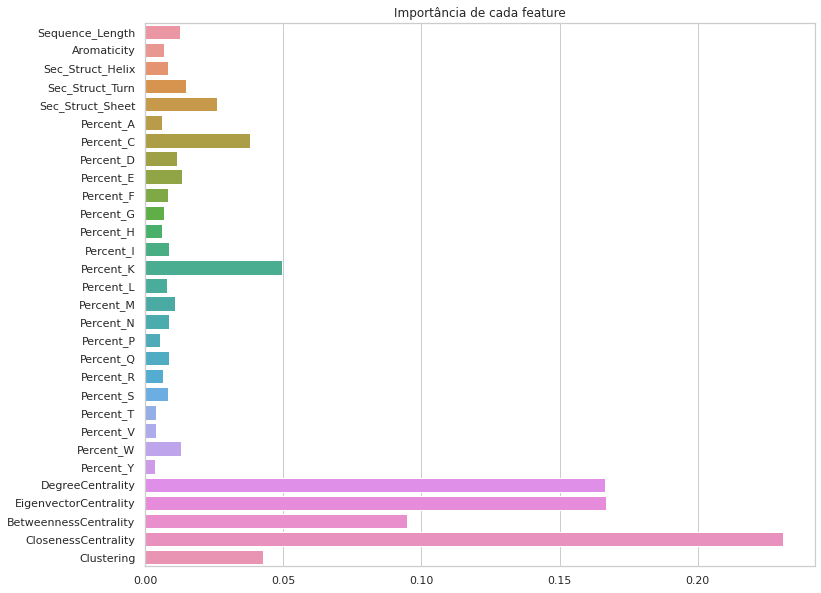

In [39]:
# Verificando a importância de cada feature

plt.rcParams['figure.figsize'] = (12,10)

importances = pd.Series(data=rfc.feature_importances_, index=X_train.columns.values)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [40]:
# Validação cruzada 
validacao_cruzada(rfc, X_train, y_train, True, sample)

Acurácia do split 0: 0.6845555100368701
Acurácia do split 1: 0.6700122900450635
Acurácia do split 2: 0.6730848013109382
Acurácia do split 3: 0.6832616267158369
Acurácia do split 4: 0.6758860889162057
Média de Acurácia na validação cruzada: 0.6773600634049829


In [41]:
y_pred = rfc.predict(X_test)

In [42]:
# Scikit-learn
print(confusion_matrix(y_test, y_pred))

[[3832 1937]
 [  74  260]]


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79      5769
           1       0.12      0.78      0.21       334

    accuracy                           0.67      6103
   macro avg       0.55      0.72      0.50      6103
weighted avg       0.93      0.67      0.76      6103

